# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The concepts behind clustering algorithms, although we will go through this throughout the project.

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

[**Task 6**](#task6): HDBSCAN

[**Task 7**](#task7): Addressing Outliers

[**Further Reading**](#further)

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [2]:
df = pd.read_csv(r'E:\ML\Coursera_Projects\ClusteringGeolocationTaxiData\taxi_data.csv')

In [3]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [4]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [5]:
df.isna().values.any()

True

In [6]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [7]:
X=np.array(df[['LON','LAT']],dtype='float64')

In [8]:
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

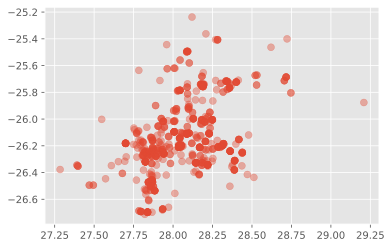

In [9]:
plt.scatter(X[:,0],X[:,1],alpha=0.4,s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [10]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=10, tiles='Stamen Toner')

for _,row in df.iterrows():
    folium.CircleMarker(
    location=[row.LAT, row.LON],
        radius=6,
        popup=re.sub(r'[^a-zA-Z ]+','',row.NAME),
        color='#178231',
        fill = True,
        fill_color='#178231'
    ).add_to(m)

In [11]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [12]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, cluster_std=0.5, random_state=4)

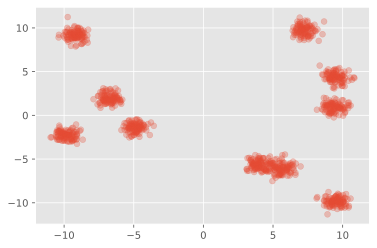

In [13]:
plt.scatter(X_blobs[:,0],X_blobs[:,1],alpha=0.3)

In [14]:
class_predictions = np.load(r'E:\ML\Coursera_Projects\ClusteringGeolocationTaxiData\sample_clusters.npy')

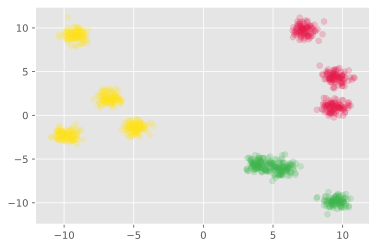

In [15]:
unique_clusters = np.unique(class_predictions)
for uc in unique_clusters:
    X = X_blobs[class_predictions==uc]
    plt.scatter(X[:,0],X[:,1],alpha=0.2,c= cols[uc])

In [16]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

In [17]:
class_predictions = np.load(r'E:\ML\Coursera_Projects\ClusteringGeolocationTaxiData\sample_clusters_improved.npy')


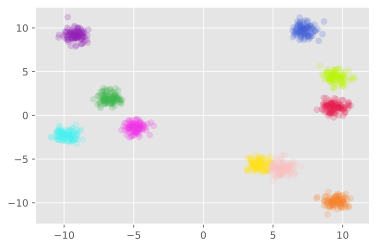

In [18]:
unique_clusters = np.unique(class_predictions)
for uc in unique_clusters:
    X = X_blobs[class_predictions==uc]
    plt.scatter(X[:,0],X[:,1],alpha=0.2,c= cols[uc])

In [19]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

<a id='task4'></a>
# Task 4: K-Means Clustering

In [20]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [21]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [22]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [25]:
X= np.array(df[['LAT','LON']],dtype='float64')
k=70
model = KMeans(n_clusters=k,random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'Cluster_Kmeans{k}'] = class_predictions

In [28]:
df['Cluster_Kmeans70'].nunique()

70

In [46]:
def cluster_map(df,cluster_column):
        m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

        for _, row in df.iterrows():
            if (row[cluster_column]==-1):
                cluster_colour = '#000000'
            else:
                cluster_colour = cols[row[cluster_column]]

            folium.CircleMarker(
                location= [row.LAT, row.LON],
                radius=5,
                popup= row[cluster_column],
                color=cluster_colour,
                fill=True,
                fill_color=cluster_colour
            ).add_to(m)
        
        return m

m= cluster_map(df,'Cluster_Kmeans70')    
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=99
Silhouette Score: 0.5686171945317242


In [47]:
m

In [48]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:44<00:00,  2.19it/s]

K=98
Silhouette Score: 0.6971995093192229


<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [55]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

In [56]:
model = DBSCAN(eps=0.01,min_samples=5).fit(X)
class_predictions = model.labels_
df['DBSCAN_CLUSTERS'] = class_predictions

In [57]:
m= cluster_map(df,'DBSCAN_CLUSTERS')


print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138256614868
Silhouette outliers as singletons: 0.5667489355530314


In [58]:
m

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [59]:
model= hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)

df['HDBSCAN_CLUSTERS'] = class_predictions

In [60]:
m= cluster_map(df,'HDBSCAN_CLUSTERS')
print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.767050436112213
Silhouette outliers as singletons: 0.638992483653762


<a id='task7'></a>
# Task 7: Addressing Outliers


In [61]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [62]:
df_train = df[df['HDBSCAN_CLUSTERS']!=-1]
df_predict = df[df['HDBSCAN_CLUSTERS']==-1]

In [76]:
X_train = np.array(df_train[['LAT','LON']],dtype='float64')
Y_train = np.array(df_train['HDBSCAN_CLUSTERS'])

X_predict = np.array(df_predict[['LAT','LON']],dtype='float64')

In [77]:
classifier.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=1)

In [78]:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params= None, n_jobs=None, n_neighbors=1, p=2, weights='uniform' )

KNeighborsClassifier(n_neighbors=1)

In [79]:
predictions = classifier.predict(X_predict)
predictions

array([26, 41, 13, 44, 57, 26, 34,  4, 60, 60, 16, 16, 61, 24, 51, 51, 51,
       58, 41, 63, 13, 45, 15, 45, 45,  6,  0, 17, 26, 26, 26, 49, 49, 53,
       49, 13, 61, 26, 26, 39, 65, 31, 31, 31,  0, 46, 46, 21, 58, 60,  6,
        5, 24,  1, 63, 34, 64, 36, 36, 16,  7,  3, 64, 41, 13, 39, 39, 39,
       41, 40, 40, 25, 59, 57, 61, 61, 62, 26, 15, 15, 59, 63,  6, 19, 61,
       61, 48,  4, 41, 21, 64, 64, 64, 61, 61, 21, 23, 38, 31, 41, 55, 55],
      dtype=int64)

In [80]:
df['CLUSTER_Hybrid']= df['HDBSCAN_CLUSTERS']

In [81]:
df.loc[df['HDBSCAN_CLUSTERS']==-1,'CLUSTER_Hybrid'] = predictions

In [82]:
m=cluster_map(df,'CLUSTER_Hybrid')

In [83]:
m

In [84]:
class_predictions = df['CLUSTER_Hybrid']
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126496933005


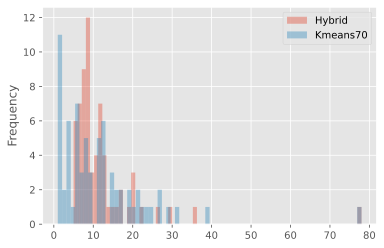

In [90]:
df['CLUSTER_Hybrid'].value_counts().plot.hist(bins=70,alpha=0.4,label='Hybrid')
df['Cluster_Kmeans70'].value_counts().plot.hist(bins=70,alpha=0.4,label='Kmeans70')
plt.legend()

<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.